In [2]:
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import numpy as np
import matplotlib.pyplot as plt
import jupyros as jr
import rospy
import time
import math
from rt2_assignment1.srv import Command
import actionlib
import rt2_assignment1.msg
from geometry_msgs.msg import Twist
from matplotlib import animation, rc
import ipywidgets as widgets
from IPython.display import display
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from nav_msgs.msg import Odometry
from rt2_assignment1.msg import PlanningActionResult
%matplotlib widget

In [5]:
# initializing the node. 
rospy.init_node('user_interface')

# user_interface client for sending start and stop command.
ui_client = rospy.ServiceProxy('/user_interface', Command)

# action client to cancel the action goal
client = actionlib.SimpleActionClient('reaching_goal', rt2_assignment1.msg.PlanningAction)

# declaring a publisher having the topic of /cmd_vel for controlling the robot's velocity
pub=rospy.Publisher('/cmd_vel', Twist, queue_size=1)
time.sleep(10)

# global variables initialisation
cancelled=0 
reached=0 
active=False
start_time=0
stop_time=0
data = list()
msg = Twist()

In [4]:
#Go_to_point behaviour with start stop button.
start_button = widgets.Button(description="START",layout=widgets.Layout(widht='auto',grid_area='b1'),
                style=widgets.ButtonStyle(button_color='green') )

stop_button = widgets.Button(description="STOP",  layout=widgets.Layout(width='auto', grid_area='b2'),
                style=widgets.ButtonStyle(button_color='red'))


def clicked_start(b): 
     global start_time
     global active
     global count
     #call the service client
     ui_client("start")      
     active=True
     take=False
     start_time=time.time()
        
def clicked_stop(b):
     global cancelled
     global stop_time
     global active
     global data
     # call the action client
     client.cancel_all_goals()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y = 0
     twist_msg.angular.z = 0
     #publish a zero velocity
     pub.publish(twist_msg)
     ui_client("stop")
     if active==True:
         cancelled = cancelled + 1 
         active=False
         stop_time=time.time()
         data.append(stop_time-start_time)
 
# on click method

start_button.on_click(clicked_start)
stop_button.on_click(clicked_stop)

# GridBox is used for displaying buttons 
widgets.GridBox(children=[start_button,stop_button],
                layout=widgets.Layout(width='90%',grid_template_rows='auto auto auto',
                grid_template_columns='25% 25% 25% 25% 25% 25% ',
                grid_template_areas='''"b1 b2 . . . "''')
               )

GridBox(children=(Button(description='START', layout=Layout(grid_area='b1'), style=ButtonStyle(button_color='g…

In [ ]:
##Subscribing action result to chech whether robot reached to its goal or not
def reached_goal_clb(msg):
  global reached
  global start_time,stop_time
  global data 
  stop_time=time.time()
  data.append(stop_time-start_time)
  start_time=time.time()
  reached = reached+1
  

jr.subscribe('/go_to_point/result',PlanningActionResult, reached_goal_clb)

In [19]:
#Adjusting velocities with slide bars
a = widgets.FloatSlider(description='Linear Velocity' ,min=-1.0, max=1.0)
a.style.handle_color = 'blue'
display(a)

b = widgets.FloatSlider(description='Angular Velocity',min=-1.0, max=1.0)
b.style.handle_color = 'blue'
display(b)


def on_value_change(change):
    global msg
    msg.linear.x = change['new']
    pub.publish(msg)
    
def on_valueang_change(change):
    global msg
    msg.angular.z = change['new']
    pub.publish(msg)

a.observe(on_value_change, names='value')
b.observe(on_valueang_change, names='value')



FloatSlider(value=0.0, description='Linear Velocity', max=1.0, min=-1.0, style=SliderStyle(handle_color='blue'…

FloatSlider(value=0.0, description='Angular Velocity', max=1.0, min=-1.0, style=SliderStyle(handle_color='blue…

In [ ]:
#Using robot with 5 buttons

forward_button = widgets.Button(description="FORWARD",layout=Layout(width='auto', grid_area='forward'),
style=ButtonStyle(button_color='green'))

backward_button = widgets.Button(description="BACKWARD",layout=Layout(width='auto', grid_area='backkward'),
style=ButtonStyle(button_color='yellow'))

right_button = widgets.Button(description="RIGHT",layout=Layout(width='auto', grid_area='right'),
style=ButtonStyle(button_color='yellow'))

left_button = widgets.Button(description="LEFT",layout=Layout(width='auto', grid_area='left'),
style=ButtonStyle(button_color='yellow'))

stop_button = widgets.Button(description="STOP",layout=Layout(width='auto', grid_area='stop'),
style=ButtonStyle(button_color='red'))



def stop():
     global cancelled
     global stop_time
     global active
     global data
     client.cancel_all_goals()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y = 0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
     ui_client("stop")
     if active==True:
         cancelled = cancelled + 1 
         active=False
         stop_time=time.time()
         data.append(stop_time-start_time)
        
def click_forward(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 1
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
    
def click_backward(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = -1
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
        
def click_left(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = 1
     pub.publish(twist_msg)
        
def click_right(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = -1
     pub.publish(twist_msg)
          
def click_stop(b):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
    
                        
forward_button.on_click(click_forward)
backward_button.on_click(click_backward)
right_button.on_click(click_right)
left_button.on_click(click_left)
stop_button.on_click(click_stop)

widgets.GridBox(children=[forward_button, backward_button, left_button, right_button ,stop_button],
                layout=widgets.Layout(width='80%',grid_template_rows='auto auto auto',
                grid_template_columns='16% 16% 16% 16% 16% 16% ',
                grid_template_areas='''". .  . forward  . ."". . backward right left . "" . .  . stop . . "''')
               )



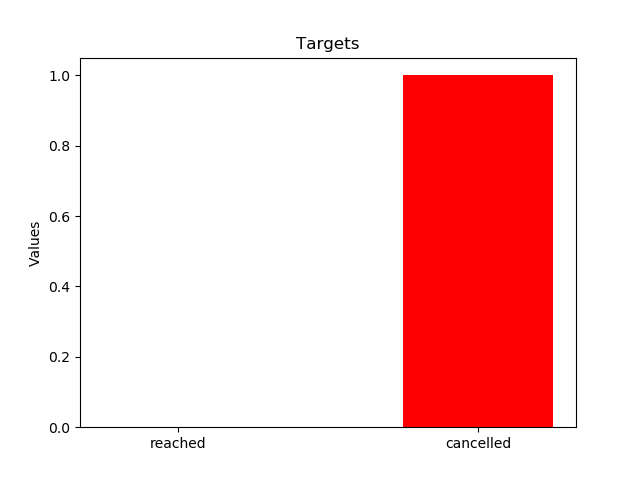

In [8]:
#barplot visiualization

y = (reached,cancelled)
index = np.arange(2)

f1,axis2= plt.bar(index,y,width=0.5,color='r')
plt.ylabel('Values')
plt.title('Targets')
plt.xticks(index, ('reached', 'cancelled'))
plt.show()


/tmp/ipykernel_50145/15669828.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig2=plt.subplot(111)


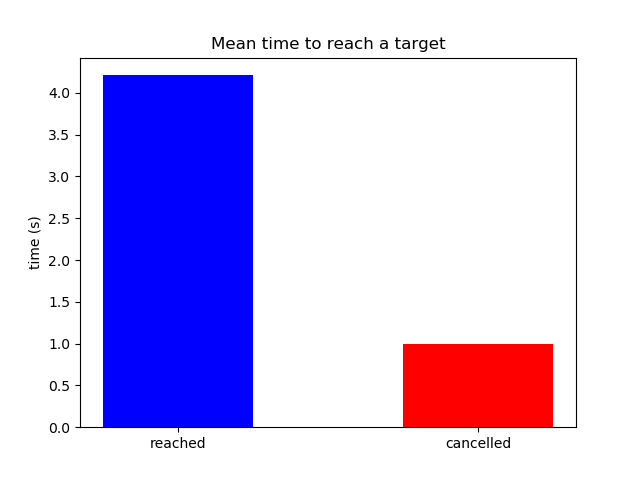

In [9]:
#histogram visualization

X=list(range(0,len(data),1))
fig2=plt.subplot(111)
plt.bar(X,data,width=0.5,color='b')
plt.ylabel('time (s)')
plt.title('Mean time to reach a target')
plt.show()


In [12]:
#Linear Velocity

c1 = time.time() #offset of timer 
time1 = list(range(0, 10))
odom_linear =list()
cmdvel_linear=list()

def init1():
    line1.set_data([], [])
    line2.set_data([], [])
    return [line1,line2]

#odom callback
def clbk_odom1(msg):
    if len(time1)>10:
      time1.pop(0)
     
    if len(odom_linear)>10:
      odom_linear.pop(0)
    ip = np.float32(msg.twist.twist.linear.x)
    iy = np.float32(time.time()-c1)
    odom_linear.append(iy)
    time1.append(ix)
    
#cmdvel callback
def clbk_cmdvel1(msg):
    if len(cmdvel_linear)>10:
      cmdvel_linear.pop(0)
    iy = np.float32(msg.linear.x)
    cmdvel_linear.append(iy)
    

jr.subscribe('/cmd_vel', Twist, clbk_cmdvel1)
jr.subscribe('/odom',Odometry, clbk_odom1)


Removing previous callback, only one redirection possible right now
[ERROR] [1645976380.762100]: bad callback: <function clbk_odom1 at 0x7fc7d6d143a0>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined

[WARN] [1645976380.767393]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.
[ERROR] [1645976380.820217]: bad callback: <function clbk_odom1 at 0x7fc7d6d143a0>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined

Removing previous callback,

[ERROR] [1645976393.424930]: bad callback: <function clbk_odom1 at 0x7fc761af2160>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined

[ERROR] [1645976393.466739]: bad callback: <function clbk_odom1 at 0x7fc761af2160>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined

[ERROR] [1645976393.519097]: bad callback: <function clbk_odom1 at 0x7fc761af2160>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_od

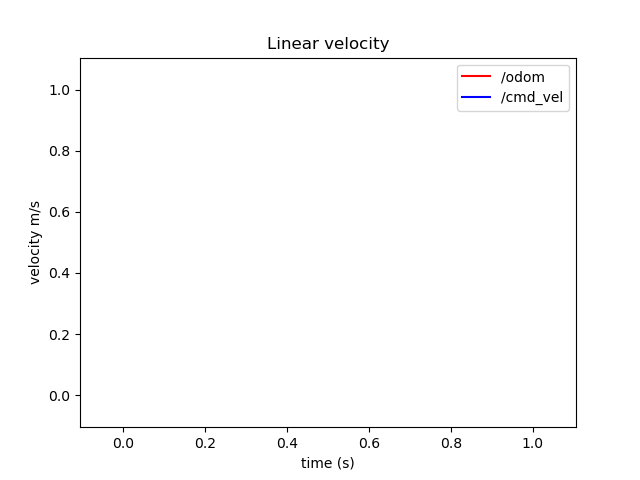

In [13]:
#Linear Velocity Plot
fig1, ax1 = plt.subplots()
line1, = ax1.plot([], [], color ='r', label ='/odom')
line2, = ax1.plot([], [], color ='b', label ='/cmd_vel')
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('velocity m/s')
ax1.set_title("Linear velocity")
plt.legend(loc='upper right')

def animate1(i):
    #refresh of line
    line1.set_data(time1, odom_linear)
    line2.set_data(time1, cmdvel_linear)
    ax1.axis([time1[0]-0.2,time1[9]+0.2,-0.5,0.5])    
    return [line1,line2]

#animator
anim1 = animation.FuncAnimation(fig1, animate1, init_func=init1,
                               frames=100, interval=20, blit=True)

In [14]:
#Angular Velocity
clock2 = time.time() 
time2 = list(range(0, 10))
odom_angular =list()
cmdvel_angular=list()

def init2():
    line3.set_data([], [])
    line4.set_data([], [])
    return [line3,line4]

def clbk_odom2(msg):
    if len(time2)>10:
      time2.pop(0)
     
    if len(odom_angular)>10:
      odom_angular.pop(0)
    iupsilon = np.float32(msg.twist.twist.angular.z)
    ix = np.float32(time.time()-clock2)
    odom_angular.append(iupsilon)
    time2.append(ix)

def clbk_cmdvel2(msg):
    if len(cmdvel_angular)>10:
      cmdvel_angular.pop(0)
    iupsilon = np.float32(msg.angular.z)
    cmdvel_angular.append(iupsilon)
    

jr.subscribe('/cmd_vel', Twist, clbk_cmdvel2)
jr.subscribe('/odom',Odometry, clbk_odom2)


Removing previous callback, only one redirection possible right now
[ERROR] [1645976397.192812]: bad callback: <function clbk_odom1 at 0x7fc761af2160>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined

Removing previous callback, only one redirection possible right now[ERROR] [1645976397.263792]: bad callback: <function clbk_odom1 at 0x7fc761af2160>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/tmp/ipykernel_50145/1024368542.py", line 23, in clbk_odom1
    time1.append(ix)
NameError: name 'ix' is not defined




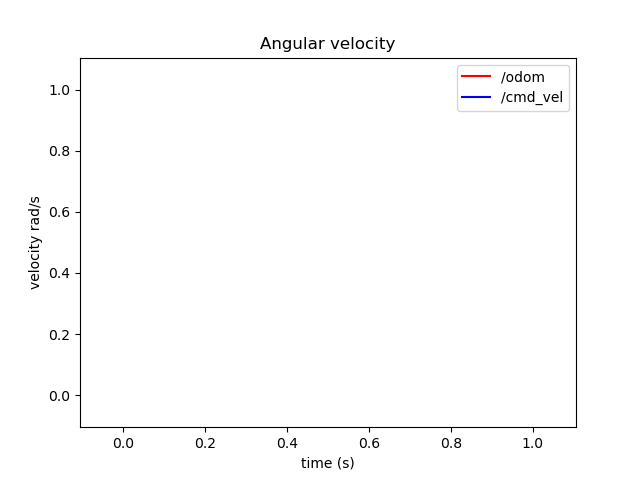

In [15]:
#Angular velocity plot
fig2, ax2 = plt.subplots()

line3, = ax2.plot([], [], color ='r', label ='/odom')
line4, = ax2.plot([], [], color ='b', label ='/cmd_vel')
ax2.set_xlabel('time (s)') 
ax2.set_ylabel('velocity rad/s')
ax2.set_title("Angular velocity")
plt.legend(loc='upper right')

def animate2(i):
    line3.set_data(time2, odom_angular)
    line4.set_data(time2, cmdvel_angular)
    ax2.axis([time2[0]-0.2,time2[9]+0.2,-0.5,0.5])
    return [line3,line4]

anim2 = animation.FuncAnimation(fig2, animate2, init_func=init2,
                               frames=100, interval=20, blit=True)



Removing previous callback, only one redirection possible right now


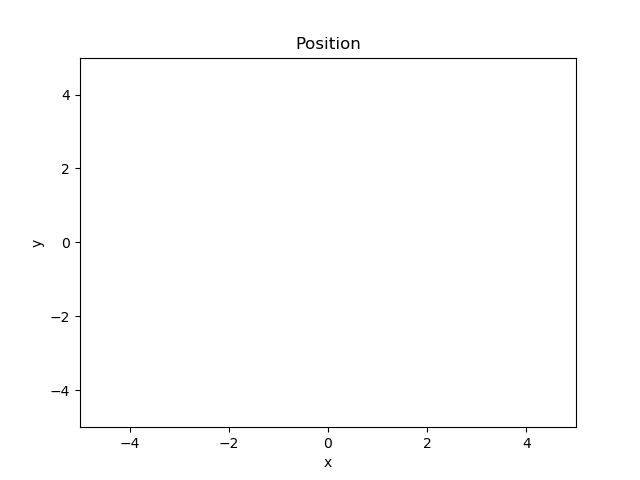

In [16]:
#Showing position

x_data=list()
y_data=list()

fig, ax = plt.subplots()

ax.set_xlim(( -5, 5))
ax.set_ylim((-5, 5))
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_title("Position")
line, = ax.plot([], [], 'ro')
    

def init():
    line.set_data([], [])
    return (line,)
    
def odom_callback(msg):
    if len(x_data)>50:
      x_data.pop(0)
      
    if len(y_data)>50:
      y_data.pop(0)
    
    iupsilon = np.float32(msg.pose.pose.position.y)
    ix = np.float32(msg.pose.pose.position.x)
    y_data.append(iupsilon)
    x_data.append(ix)
    

jr.subscribe('/odom', Odometry, odom_callback)

def animate(i):
    line.set_data(x_data, y_data)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

